**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

import seaborn
seaborn.set_context('talk')
from sqlalchemy import create_engine, text

In [5]:
import plotly
plotly.__version__

'6.1.0'

In [6]:
# # data source: Melbourne 
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

# data source: Airbnb-Melbourne
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/var/folders/9x/sk5wzh9n465bsgp0vntddj3w0000gn/T/ipykernel_41866/3089177150.py:13: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  




# Pequena exploracion de datos de las bases melf_df, airnbnb_df

Realizamos una pequena exploracion de los dataframes melf_df y airbnb_df, y entendemos que las bases de datos, mismo que puedan ser relacionadas, se encuentran con diferentes niveles de informaciones. La base melf_df es una base con nivel de informacion de precios de ventas de inmuebles de diversos barrios en la ciudad de Melbourne, Australia (entendemos que el campo 'suburb' puede ser considerado el barrio segun la siguiente pagina de referencia de https://www.melbourne.vic.gov.au/suburbs-and-neighbourhoods), mientras que la base airbnb_df tiene informacion de alquiler de diarios/semanal/mensual de diferentes ciudades Australia, incluyendo Melbourne. Tambien consideramos y entendemos que cada registro de la base puede tener un 'unique_id' para cada inmueble que puede ser considerado el campo 'Postcode', mientras que en la base airbnb_df ese campo seria 'zipcode', porque lo que podemos conectar ambas las fuentes considerando mediante estos campos. Pero como en algunas de las preguntas necesitamos responder y dar informaciones sobre cantidade de habitaciones, precio promedio de las propiedades o las propiedades mas caras, si realizamos un JOIN entre las bases vamos a terminando con informacion solamente para la ciudad de Melbourne y esto es debido a que la base airbnb generada en clase no tiene la informacion de la cantidad de habitaciones, tipo, precio de venta de inmueble, por esta razon consideramos trabajar directamente con la base melf_df, para responder las preguntas del apartado 3.

Nota: Realizamos una pequena exploracion de otros columnas que estan presentes en la base de datos 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv' y podemos ver que tiene informacion complementar que no fue considera en la clase como por ejemplo la cantidad de habitaciones, banos, etc. Por exemplo:

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighborhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 'license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']


# Creacion de Base de datos e ingesta

In [7]:
engine = create_engine("sqlite:///melbourne.db", echo=True)

# Working data for the analysis
airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias
melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int

In [8]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  object        
 1   Address        13580 non-null  object        
 2   Rooms          13580 non-null  int64         
 3   Type           13580 non-null  object        
 4   Price          13580 non-null  float64       
 5   Method         13580 non-null  object        
 6   SellerG        13580 non-null  object        
 7   Date           5138 non-null   datetime64[ns]
 8   Distance       13580 non-null  float64       
 9   Postcode       13580 non-null  float64       
 10  Bedroom2       13580 non-null  int64         
 11  Bathroom       13580 non-null  int64         
 12  Car            13580 non-null  int64         
 13  Landsize       13580 non-null  float64       
 14  BuildingArea   7130 non-null   float64       
 15  YearBuilt      8205

In [9]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   description              22563 non-null  object 
 1   neighborhood_overview    14424 non-null  object 
 2   street                   22895 non-null  object 
 3   neighborhood             17082 non-null  object 
 4   city                     22895 non-null  object 
 5   suburb                   22872 non-null  object 
 6   state                    22834 non-null  object 
 7   zipcode                  22749 non-null  float64
 8   latitude                 22895 non-null  float64
 9   longitude                22895 non-null  float64
 10  price                    22895 non-null  int64  
 11  weekly_price             2524 non-null   float64
 12  monthly_price            1891 non-null   float64
 13  zipcode_int              22895 non-null  int64  
 14  weekly_price_calculate

In [10]:
# Create a table 'melb' in the SQLite database
melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

2025-05-26 21:19:36,160 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:19:36,170 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-26 21:19:36,171 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:19:36,172 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-26 21:19:36,172 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:19:36,173 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-26 21:19:36,173 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:19:36,174 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-26 21:19:36,176 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:19:36,176 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-26 21:19:36,176 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:1

13580

In [11]:
# Create a table 'airbnb' in the SQLite database and insert the data
airbnb_df.to_sql('airbnb', con=engine, if_exists='replace', index=False)

2025-05-26 21:20:06,636 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:20:06,663 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb")
2025-05-26 21:20:06,664 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:20:06,664 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb")
2025-05-26 21:20:06,665 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:20:06,665 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-26 21:20:06,665 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:20:06,666 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-26 21:20:06,666 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:20:06,666 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("airbnb")
2025-05-26 21:20:06,667 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-2

22895

- Nota: 
Vimos que los datos cuando fueron guardados en la base de datos SQLite usando a estrutura interna de Pandas, algunos campos como 'Date', 'Bathroom2', 'Car', 'Bathroom' fueron en formatos que no fueron especificados. Por esa realizamos algunas modificaciones previamente en esos campos para poder guardarlos en un formato mas apto para cada campo. Tambien, pudimos observar en la documentacion de pandas que existe una parametro (dtype={'name_column1':Integer(), 'name_column2':Float(),.....}) que puede ser pasado en el momento de guardar los datos especificando los formatos de cada campo.

In [16]:
# Para saber el schema de la tabla melb
schema_melb=pd.read_sql(text("""PRAGMA table_info('melb')"""), con=engine)
schema_melb[['name','type']]

2025-05-26 21:24:56,121 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:24:56,123 INFO sqlalchemy.engine.Engine PRAGMA table_info('melb')
2025-05-26 21:24:56,125 INFO sqlalchemy.engine.Engine [cached since 171.5s ago] ()
2025-05-26 21:24:56,137 INFO sqlalchemy.engine.Engine ROLLBACK


,name,type
0,Suburb,TEXT
1,Address,TEXT
2,Rooms,BIGINT
3,Type,TEXT
4,Price,FLOAT
5,Method,TEXT
6,SellerG,TEXT
7,Date,DATETIME
8,Distance,FLOAT
9,Postcode,FLOAT


In [17]:
schema_airbnb=pd.read_sql(text("""PRAGMA table_info('melb')"""), con=engine)
schema_airbnb[['name','type']]

2025-05-26 21:25:18,550 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:25:18,557 INFO sqlalchemy.engine.Engine PRAGMA table_info('melb')
2025-05-26 21:25:18,558 INFO sqlalchemy.engine.Engine [cached since 193.9s ago] ()
2025-05-26 21:25:18,563 INFO sqlalchemy.engine.Engine ROLLBACK


,name,type
0,Suburb,TEXT
1,Address,TEXT
2,Rooms,BIGINT
3,Type,TEXT
4,Price,FLOAT
5,Method,TEXT
6,SellerG,TEXT
7,Date,DATETIME
8,Distance,FLOAT
9,Postcode,FLOAT


In [24]:
queryTotalRegistrosPorCiudad = "select count(*) as total from melb"
resultTotalRegistrosPorCiudad = pd.read_sql(queryTotalRegistrosPorCiudad, con=engine)
print(f"Cantidad de registros totales para la ciudad de Melbourne :{resultTotalRegistrosPorCiudad['total'][0]}")

2025-05-26 21:29:13,579 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:29:13,581 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total from melb")
2025-05-26 21:29:13,582 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,583 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total from melb")
2025-05-26 21:29:13,584 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,585 INFO sqlalchemy.engine.Engine select count(*) as total from melb
2025-05-26 21:29:13,586 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,590 INFO sqlalchemy.engine.Engine ROLLBACK
Cantidad de registros totales para la ciudad de Melbourne :13580


In [28]:
queryTotalRegistrosPorBarrioYCiudad = "select suburb, count(*) as total from melb group by suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pd.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
print("Cantidad de registros totales por barrio en la ciudad de Melbourne:")
resultTotalRegistrosPorBarrioYCiudad

2025-05-26 21:31:14,034 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:31:14,036 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select suburb, count(*) as total from melb group by suburb order by total desc;")
2025-05-26 21:31:14,037 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,039 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select suburb, count(*) as total from melb group by suburb order by total desc;")
2025-05-26 21:31:14,039 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,040 INFO sqlalchemy.engine.Engine select suburb, count(*) as total from melb group by suburb order by total desc;
2025-05-26 21:31:14,040 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,107 INFO sqlalchemy.engine.Engine ROLLBACK
Cantidad de registros totales por barrio en la ciudad de Melbourne:


,Suburb,total
0,Reservoir,359
1,Richmond,260
2,Bentleigh East,249
3,Preston,239
4,Brunswick,222
...,...,...
309,Bullengarook,1
310,Brookfield,1
311,Beaconsfield Upper,1
312,Bacchus Marsh,1


In [31]:
# - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total from melb where rooms > 2 order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pd.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
print(f"Cantidad de propiedades com más de 2 habitaciones en la ciudad de Melbourne: {resultTotalRegistrosPorCiudadConMasDe2Habitaciones['total'][0]}")

2025-05-26 21:33:23,983 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:33:23,984 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total from melb where rooms > 2 order by total desc;")
2025-05-26 21:33:23,985 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:33:23,986 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total from melb where rooms > 2 order by total desc;")
2025-05-26 21:33:23,986 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:33:23,987 INFO sqlalchemy.engine.Engine select count(*) as total from melb where rooms > 2 order by total desc;
2025-05-26 21:33:23,987 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:33:23,995 INFO sqlalchemy.engine.Engine ROLLBACK
Cantidad de propiedades com más de 2 habitaciones en la ciudad de Melbourne: 9251


In [32]:
# - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select type, round(avg(price) ,2) as precio_promedio  from melb group by type order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pd.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

2025-05-26 21:34:15,914 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:34:15,915 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select type, round(avg(price) ,2) as precio_promedio  from melb group by type order by precio_promedio desc;")
2025-05-26 21:34:15,916 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:34:15,916 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select type, round(avg(price) ,2) as precio_promedio  from melb group by type order by precio_promedio desc;")
2025-05-26 21:34:15,917 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:34:15,917 INFO sqlalchemy.engine.Engine select type, round(avg(price) ,2) as precio_promedio  from melb group by type order by precio_promedio desc;
2025-05-26 21:34:15,917 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:34:15,927 INFO sqlalchemy.engine.Engine ROLLBACK


,Type,precio_promedio
0,h,1242664.76
1,t,933735.05
2,u,605127.48


In [35]:
# - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select suburb, round(avg(price) ,2) as precio_promedio from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pd.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras

2025-05-26 21:36:10,075 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:36:10,077 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select suburb, round(avg(price) ,2) as precio_promedio from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-26 21:36:10,078 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:10,082 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select suburb, round(avg(price) ,2) as precio_promedio from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-26 21:36:10,083 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:10,083 INFO sqlalchemy.engine.Engine select suburb, round(avg(price) ,2) as precio_promedio from melb group by suburb order by precio_promedio desc limit 5;
2025-05-26 21:36:10,084 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:10,095 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,precio_promedio
0,Kooyong,2185000.00
1,Canterbury,2180240.74
2,Middle Park,2082529.41
3,Albert Park,1941355.07
4,Brighton,1930158.00


In [36]:
queryJoin = """
select m.*, a.*
from melb m 
left join airbnb a 
    on m.Postcode_int = a.zipcode_int
LIMIT 100
"""
resultJoin = pd.read_sql(queryJoin, con=engine)
resultJoin

2025-05-26 21:36:53,429 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:36:53,430 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("
select m.*, a.*
from melb m 
left join airbnb a 
    on m.Postcode_int = a.zipcode_int
LIMIT 100
")
2025-05-26 21:36:53,433 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:53,436 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("
select m.*, a.*
from melb m 
left join airbnb a 
    on m.Postcode_int = a.zipcode_int
LIMIT 100
")
2025-05-26 21:36:53,436 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:53,438 INFO sqlalchemy.engine.Engine 
select m.*, a.*
from melb m 
left join airbnb a 
    on m.Postcode_int = a.zipcode_int
LIMIT 100

2025-05-26 21:36:53,439 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:36:53,890 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,state,zipcode,latitude,longitude,price,weekly_price,monthly_price,zipcode_int,weekly_price_calculate,monthly_price_calculate
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.810196,145.008976,125,NaN,NaN,3067,875.0,3750.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.810981,145.014269,96,NaN,NaN,3067,672.0,2880.0
2,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.809320,144.991833,100,NaN,NaN,3067,700.0,3000.0
3,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.808998,144.992535,55,NaN,NaN,3067,385.0,1650.0
4,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.808703,144.992925,90,NaN,NaN,3067,630.0,2700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.804382,144.996753,138,831.0,3461.0,3067,831.0,3461.0
96,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.803140,144.999114,46,300.0,NaN,3067,300.0,1380.0
97,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.801900,144.999080,101,NaN,NaN,3067,707.0,3030.0
98,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12 00:00:00.000000,2.5,3067.0,...,VIC,3067.0,-37.802802,144.997031,150,NaN,NaN,3067,1050.0,4500.0


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [37]:
melb_df.groupby('Regionname').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median'),
    precio_max=('Price', 'max'),
    precio_min=('Price', 'min')
).reset_index().sort_values('total', ascending=False)


,Regionname,total,precio_promedio,precio_median,precio_max,precio_min
5,Southern Metropolitan,4695,1.372963e+06,1250000.0,8000000.0,131000.0
2,Northern Metropolitan,3890,8.981711e+05,806250.0,4525000.0,145000.0
6,Western Metropolitan,2948,8.664205e+05,793000.0,3900000.0,85000.0
0,Eastern Metropolitan,1471,1.104080e+06,1010000.0,4000000.0,288000.0
4,South-Eastern Metropolitan,450,9.229438e+05,850000.0,9000000.0,266000.0
1,Eastern Victoria,53,6.999808e+05,670000.0,1085000.0,400000.0
3,Northern Victoria,41,5.948293e+05,540000.0,1355000.0,330000.0
7,Western Victoria,32,3.975234e+05,400000.0,710000.0,280500.0


In [38]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades
queryEjercicio2 = "select * from melb"
resultCorrelacion = pd.read_sql_query(queryEjercicio2, engine).select_dtypes(include=[np.number]).corr().abs()
resultCorrelacion['Price'].sort_values(ascending=False)


2025-05-26 21:38:18,850 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:38:18,851 INFO sqlalchemy.engine.Engine select * from melb
2025-05-26 21:38:18,852 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:38:18,964 INFO sqlalchemy.engine.Engine ROLLBACK


Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
YearBuilt        0.323617
Car              0.234825
Lattitude        0.212934
Longtitude       0.203656
Distance         0.162522
Postcode         0.107867
Postcode_int     0.107867
BuildingArea     0.090981
Propertycount    0.042153
Landsize         0.037507
Name: Price, dtype: float64

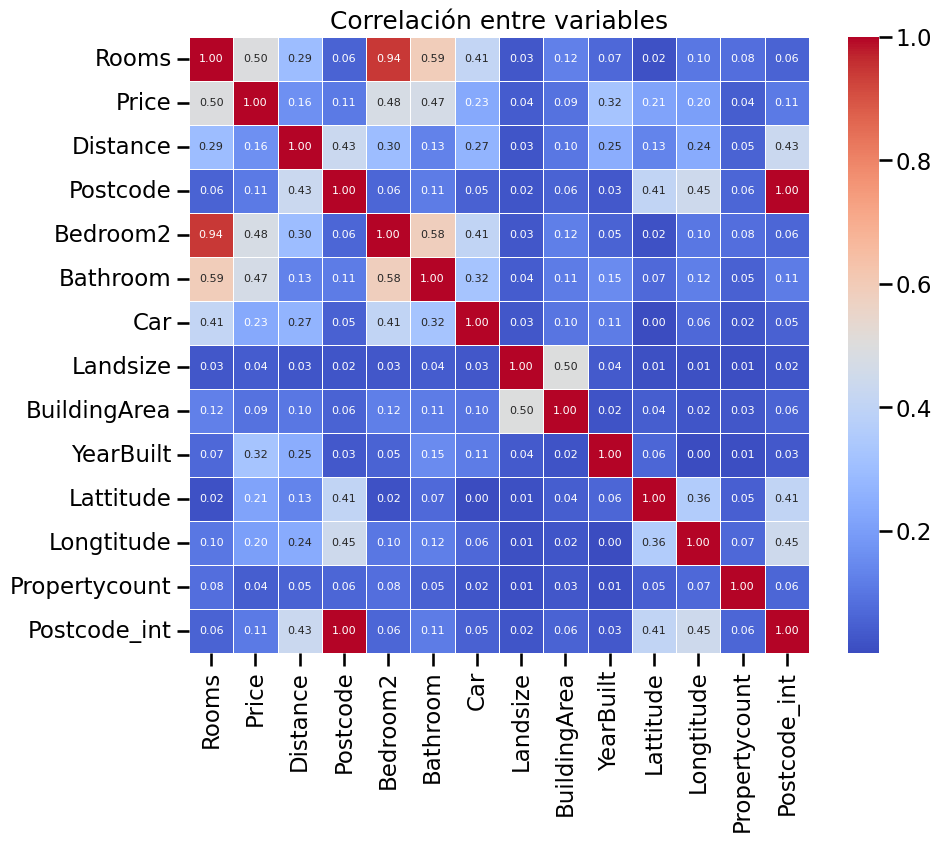

In [39]:
# grafico que representa la correlacion entre las variables
plt.figure(figsize=(10, 8))
seaborn.heatmap(resultCorrelacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlación entre variables')
plt.show()


In [40]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
quereSelectedColumns = "select Price, Rooms, Bedroom2, Bathroom  from melb"
rows = pd.read_sql(quereSelectedColumns, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

rows.info()

2025-05-26 21:38:42,583 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:38:42,587 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-26 21:38:42,589 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:38:42,594 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-26 21:38:42,595 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:38:42,597 INFO sqlalchemy.engine.Engine select Price, Rooms, Bedroom2, Bathroom  from melb
2025-05-26 21:38:42,598 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:38:42,655 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 0.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     13580 non-null  float64
 1   

In [43]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom','Regionname']
result = pd.read_sql(queryEjercicio2, con=engine)[columnasSeleccionadas]
result.sort_values(by='Price', ascending=True)


2025-05-26 21:40:07,255 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:40:07,256 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select * from melb")
2025-05-26 21:40:07,256 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:40:07,257 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select * from melb")
2025-05-26 21:40:07,257 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:40:07,258 INFO sqlalchemy.engine.Engine select * from melb
2025-05-26 21:40:07,259 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:40:07,344 INFO sqlalchemy.engine.Engine ROLLBACK


,Price,Rooms,Bedroom2,Bathroom,Regionname
2652,85000.0,1,1,1,Western Metropolitan
1805,131000.0,4,4,1,Southern Metropolitan
7303,145000.0,1,2,1,Western Metropolitan
1927,145000.0,4,3,1,Northern Metropolitan
7940,160000.0,1,1,1,Southern Metropolitan
...,...,...,...,...,...
12557,6400000.0,5,5,2,Southern Metropolitan
3616,6500000.0,6,6,6,Southern Metropolitan
9575,7650000.0,4,4,2,Southern Metropolitan
7692,8000000.0,5,5,5,Southern Metropolitan


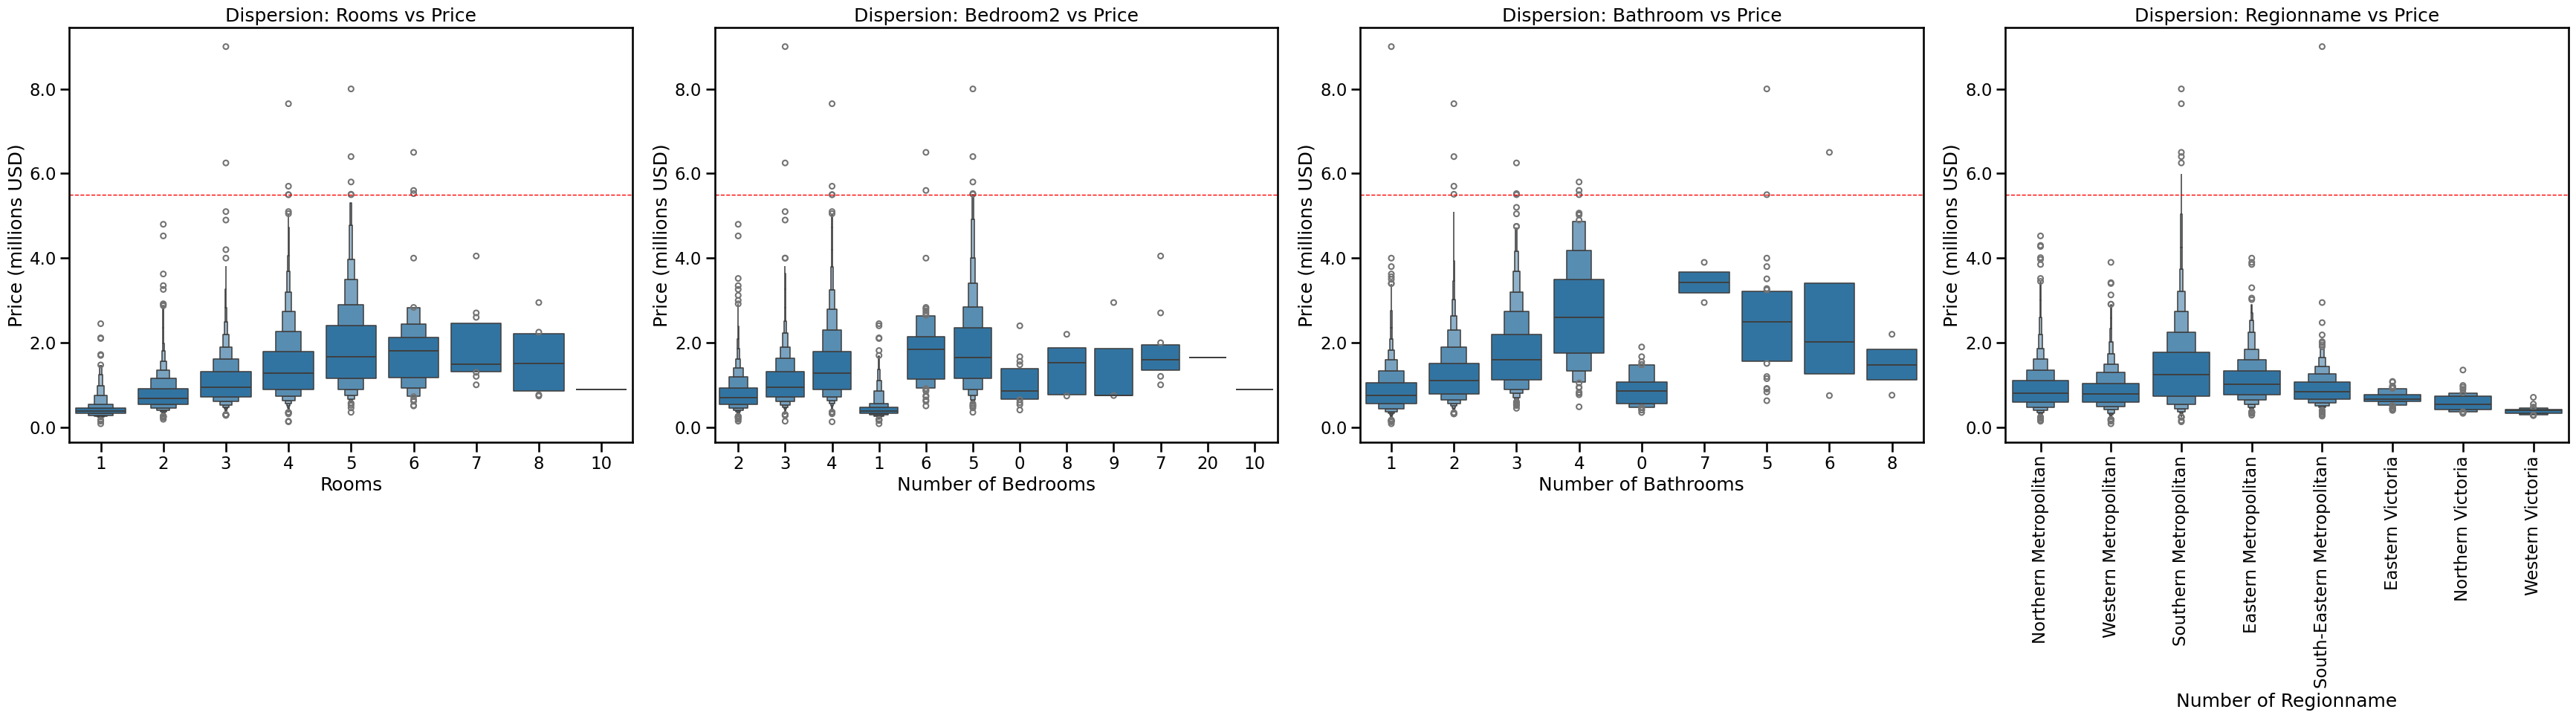

In [52]:
# 2.  Mostrar la dispersión o distribución de las columnas seleccionadas.

from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

# Formateador para mostrar los precios en millones
def millones(x, pos):
    return f'{x * 1e-6:.1f}'

formatter = FuncFormatter(millones)

# Asegurar que 'Bedroom2' y Bathroom sean categóricas para evitar decimales en el eje x
result['Bedroom2'] = result['Bedroom2'].astype(int).astype(str)
result['Bathroom'] = result['Bathroom'].astype(int).astype(str)

# Crear una figura con 1 fila y 3 columnas para los gráficos
fig, axes = plt.subplots(1, 4, figsize=(35, 10))  # Ajusta el figsize según necesidad

# Gráfico Rooms vs Price en el primer subplot (índice 0)
seaborn.boxenplot(x='Rooms', y='Price', data=result, ax=axes[0])
axes[0].yaxis.set_major_formatter(formatter)
axes[0].axhline(y=5.5e6, color='red', linestyle='--', linewidth=1)  # Línea horizontal
axes[0].set_title('Dispersion: Rooms vs Price')
axes[0].set_xlabel('Rooms')
axes[0].set_ylabel('Price (millions USD)')

# Gráfico Bedroom2 vs Price en el segundo subplot (índice 1)
seaborn.boxenplot(x='Bedroom2', y='Price', data=result, ax=axes[1])
axes[1].yaxis.set_major_formatter(formatter)
axes[1].axhline(y=5.5e6, color='red', linestyle='--', linewidth=1)  # Línea horizontal
axes[1].set_title('Dispersion: Bedroom2 vs Price')
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Price (millions USD)')

# Gráfico Bathroom vs Price en el tercer subplot (índice 2)
seaborn.boxenplot(x='Bathroom', y='Price', data=result, ax=axes[2])
axes[2].yaxis.set_major_formatter(formatter)
axes[2].axhline(y=5.5e6, color='red', linestyle='--', linewidth=1)  # Línea horizontal
axes[2].set_title('Dispersion: Bathroom vs Price')
axes[2].set_xlabel('Number of Bathrooms')
axes[2].set_ylabel('Price (millions USD)')

# Gráfico Bathroom vs Price en el tercer subplot (índice 2)
seaborn.boxenplot(x='Regionname', y='Price', data=result, ax=axes[3])
axes[3].yaxis.set_major_formatter(formatter)
axes[3].axhline(y=5.5e6, color='red', linestyle='--', linewidth=1)  # Línea horizontal
axes[3].set_title('Dispersion: Regionname vs Price')
axes[3].set_xlabel('Number of Regionname')
axes[3].set_ylabel('Price (millions USD)')
axes[3].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x para mejor visibilidad


plt.tight_layout()
plt.show()

2025-05-26 21:48:48,625 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:48:48,640 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-26 21:48:48,647 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:48:48,648 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-26 21:48:48,648 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:48:48,649 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-26 21:48:48,649 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:22,307 INFO sqlalchemy.engine.Engine ROLLBACK


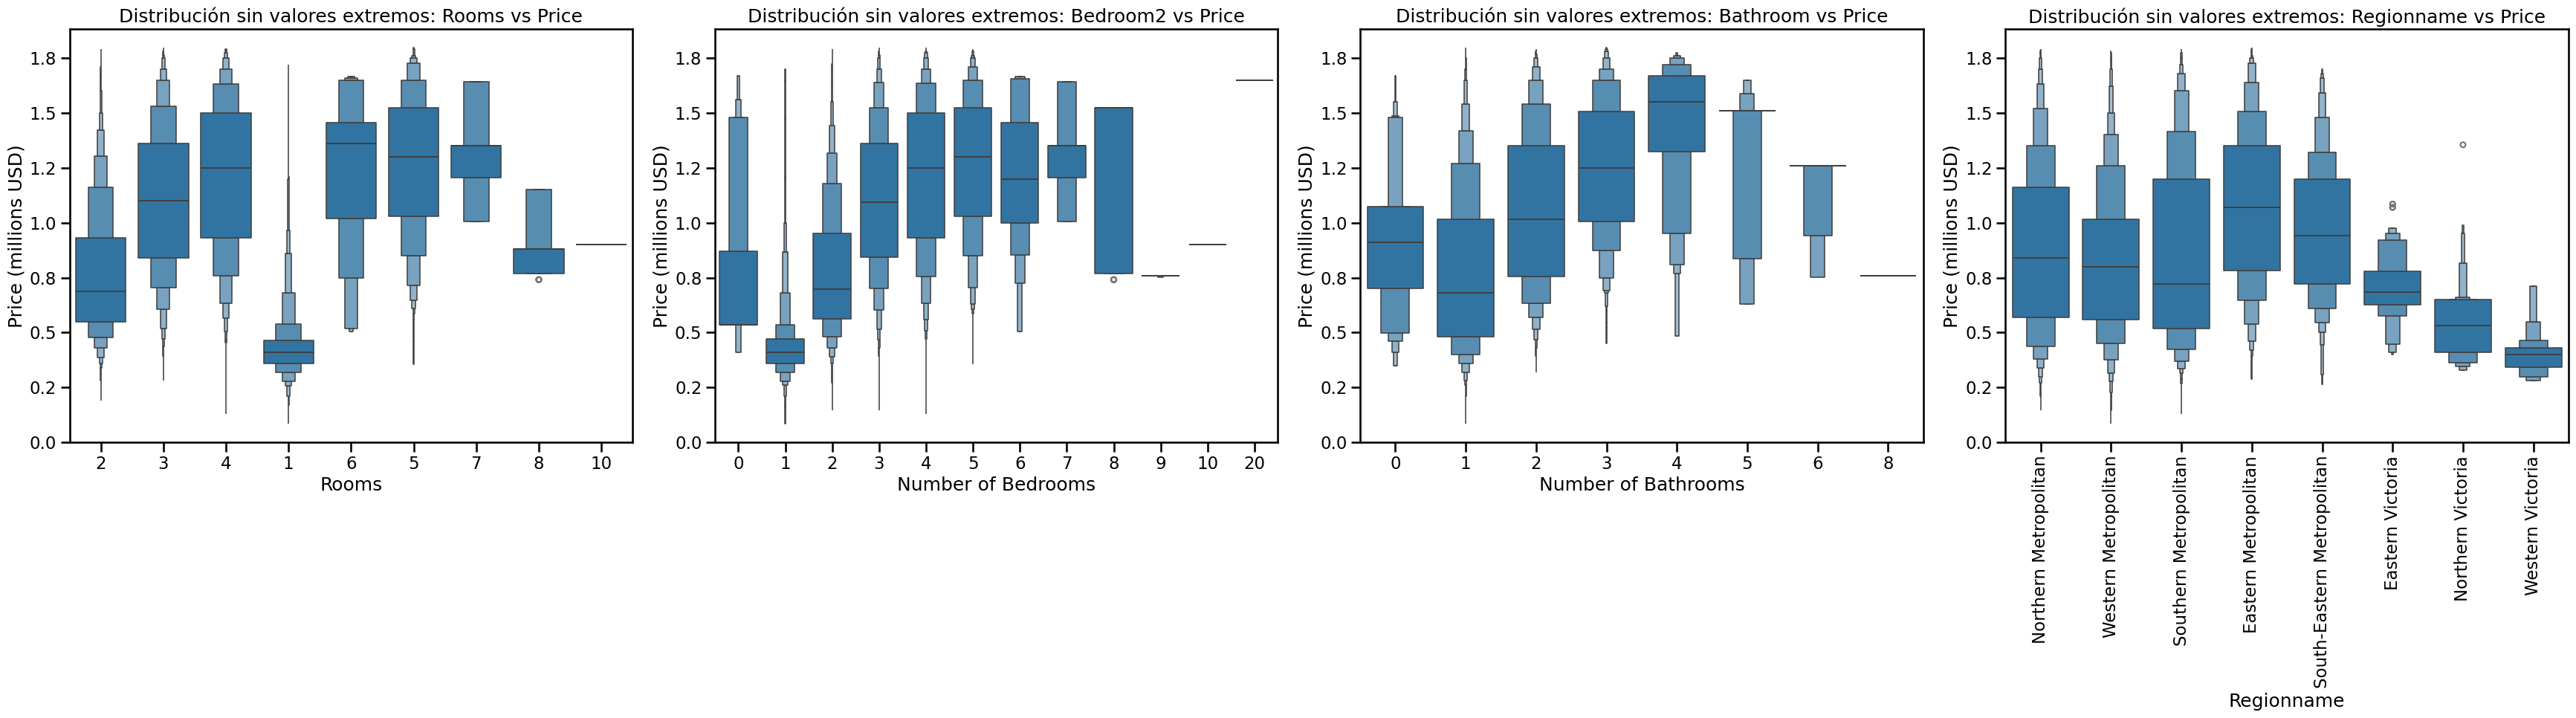

In [53]:
#Eliminar valores atípicos de propiedades con valores mayor a 6 millones y graficar

# Formateador para mostrar los precios en millones
def millones(x, pos):
    return f'{x * 1e-6:.1f}' # Added 'M' for clarity

formatter = FuncFormatter(millones)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode"
resultJoin_unfiltered = pd.read_sql(queryJoin, con=engine)

# Calcula el cuantil en la columna 'Price' de los datos unidos sin filtrar
quantile = resultJoin_unfiltered['Price'].quantile(0.90)

# Filtra los datos unidos basándose en el cuantil calculado
resultJoin_filtered = resultJoin_unfiltered[resultJoin_unfiltered['Price'] < quantile].copy()

# Crear una figura con 1 fila y 4 columnas para los gráficos
fig, axes = plt.subplots(1, 4, figsize=(35, 10))  # Ajusta el figsize según sea necesario

# Gráfico Rooms vs Price en el primer subplot (índice 0)
resultJoin_filtered['Rooms'] = resultJoin_filtered['Rooms'].fillna(-1).astype(int).astype(str)
seaborn.boxenplot(x='Rooms', y='Price', data=resultJoin_filtered, ax=axes[0])
axes[0].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[0].set_title('Distribución sin valores extremos: Rooms vs Price')
axes[0].set_xlabel('Rooms')
axes[0].set_ylabel('Price (millions USD)')

# Gráfico Bedroom2 vs Price en el segundo subplot (índice 1)
seaborn.boxenplot(x='Bedroom2', y='Price', data=resultJoin_filtered, ax=axes[1])
axes[1].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[1].set_title('Distribución sin valores extremos: Bedroom2 vs Price')
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Price (millions USD)')


# Gráfico Bathroom vs Price en el tercer subplot (índice 2)
seaborn.boxenplot(x='Bathroom', y='Price', data=resultJoin_filtered, ax=axes[2])
axes[2].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[2].set_title('Distribución sin valores extremos: Bathroom vs Price')
axes[2].set_xlabel('Number of Bathrooms')
axes[2].set_ylabel('Price (millions USD)')

# Gráfico Regionname vs Price en el cuarto subplot (índice 3)
seaborn.boxenplot(x='Regionname', y='Price', data=resultJoin_filtered, ax=axes[3])
axes[3].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[3].set_title('Distribución sin valores extremos: Regionname vs Price')
axes[3].set_xlabel('Regionname')
axes[3].set_ylabel('Price (millions USD)')
axes[3].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x para mejor visibilidad

plt.tight_layout()
plt.show()

2025-05-26 21:49:42,610 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:49:42,612 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-26 21:49:42,613 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:42,618 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-26 21:49:42,618 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:42,619 INFO sqlalchemy.engine.Engine select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000
2025-05-26 21:49:42,619 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:43,275 INFO sqlalchemy.engine.Engine ROLLBACK
2025-05-26 21:49:43,275 INFO sqlalchemy.engine.Engin

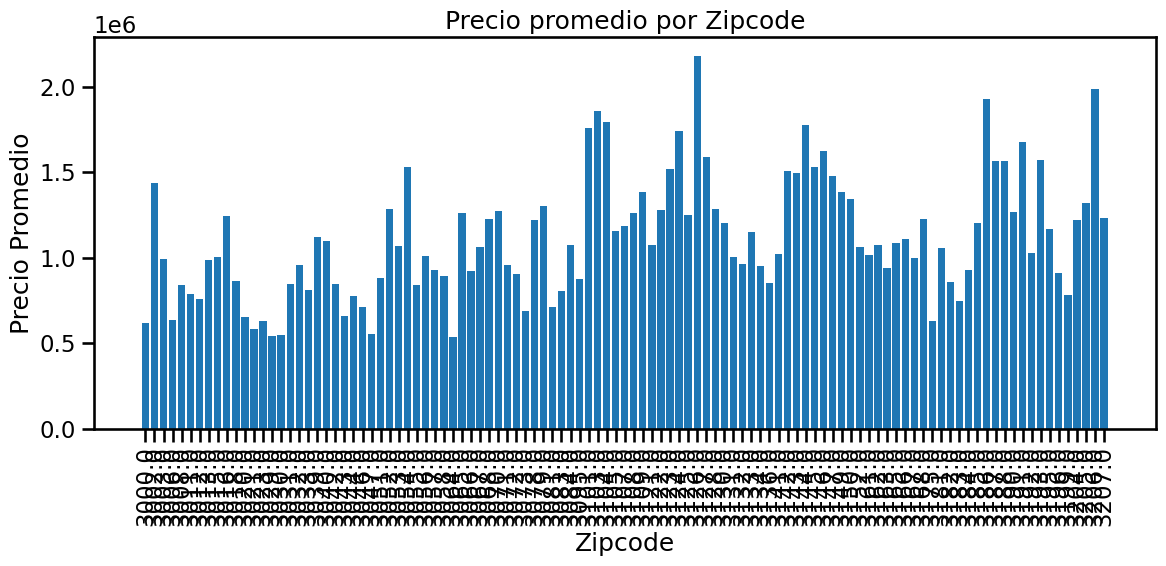

In [54]:
# Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
#   1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
#   2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
#   3. Mostrar un gráfico zipcode vs airbnb_price_median. ()
#   4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
#   5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
queryZipCode = "select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000"
resultJoin = pd.read_sql(queryZipCode, con=engine)
zipcodes = resultJoin['zipcode'].tolist()
zipcodes

queryZipCodeClear = "select * from melb m inner join airbnb a on a.zipcode = m.Postcode where a.zipcode in (" + ','.join(map(str, zipcodes)) + ")"	
resultqueryZipCodeClear = pd.read_sql(queryZipCodeClear, con=engine)
resultqueryZipCodeClear

# resultqueryZipCodeClear.groupby('zipcode').agg(
#     total=('Price', 'count'),
#     precio_promedio=('Price', 'mean'),
#     precio_median=('Price', 'median')
# ).reset_index().sort_values('total', ascending=False)

df_zipcode = resultqueryZipCodeClear.groupby('zipcode', as_index=False)['Price'].mean().rename(columns={'Price': 'precio_promedio'})

plt.figure(figsize=(12, 6))
plt.bar(df_zipcode['zipcode'].astype(str), df_zipcode['precio_promedio'])
plt.xlabel('Zipcode')
plt.ylabel('Precio Promedio')
plt.title('Precio promedio por Zipcode')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


-	Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. NO es necesario que realicen la implementación.
Si se contara con algún algoritmo capaz de encontrar ubicaciones cercanas a una propiedad se podría analizar la “accesibilidad al transporte público”, aspecto muy valorado al momento de alquilar o comprar una propiedad cuando no se posee un vehículo propio. Con esta información se podrían definir categorías como por ejemplo: "menos de 300m", "entre 300m y 1km", "más de 1km”. En general, las propiedades con mejor conectividad suelen tener mayor demanda y precios más altos.
Siguiendo bajo esta hipótesis, la “Distancia a x punto turístico” también sería relevante en el data set de AirBnB ya que generalmente al tratarse de alquileres temporales destinados a turismo suele ser un indicador clave de decisión al momento de elegir la propiedad, por lo tanto también incide en el precio de la propiedad
-	Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
Si las coordenadas geoespaciales estuvieran disponibles podrían utilizarse de diferentes maneras para mejorar la predicción de precios. Por ejemplo, podría usarse para calcular un precio promedio dentro de un radio determinado, lo cual ayudaría a comprender mejor la zona, contextualizando la propiedad en su entorno sin tener la limitación del CP o el barrio.
Además, las coordenadas permitirían calcular la distancia a diferentes puntos de interés, como escuelas, hospitales, puntos turísticos, entre otros. Esta información es muy valorada cuando se trata de alquileres temporarios ya que puede influir al momento de elegir el alojamiento. También puede ser clave al momento de tomar la decisión de comprar una propiedad, ya que se pueden visualizar los servicios disponibles y si es acorde al estilo de vida que desean los compradores.

-	¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

El uso de coordenadas geográficas posibilitaría incorporar variables espaciales más ricas y precisas, mejorando tanto la segmentación como la predicción de precios en contextos urbanos. (REVISAR)


In [49]:
#5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
#en primer lugar, crearia un mapa para visualizar la ubicacion de las propiedades, junto con características de las mismas

import plotly.express as px
data = melb_df.sample(300)
fig = px.scatter_geo(
    data, lat=data.Lattitude, lon=data.Longtitude, color=data.Price,
    hover_name=data.Suburb,
    hover_data=['YearBuilt', 'Type', 'Rooms', 'Bathroom']
    )
fig.update_geos(fitbounds="locations")
fig.show()

In [54]:
# ejemplo: Calcular distancias a puntos de interés: Centro de la ciudad, Paradas de transporte público, Centros comerciales o parques

# Para calcular la distancia al centro de Melbourne

%pip install geopy
from geopy.distance import geodesic

# ejemplo: distancia al centro de Melbourne
melbourne_center = (-37.8136, 144.9631)
data['dist_to_cbd'] = data.apply(lambda row: geodesic((row['Lattitude'], row['Longtitude']), melbourne_center).km, axis=1)
# Mostrar las primeras filas del DataFrame con la nueva columna
print(data[['Suburb', 'Lattitude', 'Longtitude', 'dist_to_cbd']].head())

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.
              Suburb  Lattitude  Longtitude  dist_to_cbd
1392  Brunswick West     -37.75      144.93         7.54
7673      Camberwell     -37.84      145.06         9.23
6967   Hawthorn East     -37.83      145.04         7.47
8030             Kew     -37.79      145.03         6.53
2182       Doncaster     -37.77      145.13        15.24


## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)

In [ ]:
resultJoin_filtered.to_sql('melb_airbnb_joined_filter', con=engine, if_exists='replace', index=False)
resultJoin.to_sql('melb_airbnb_joined_all', con=engine, if_exists='replace', index=False)
queryZipCodeClear.to_sql('melb_airbnb_zipcode', con=engine, if_exists='replace', index=False)
df_zipcode.to_sql('melb_airbnb_zipcode_avg', con=engine, if_exists='replace', index=False)

In [42]:
import pandas as pd
import datetime as dt
import requests
import io
from sqlalchemy import create_engine, text
import os
#from decouple import config
import logging

In [43]:
# En lugar de usar prints para ver el avance a medida que va corriendo el script se utilizan los logs.
# Los logs basicamente son registros que se van dejando para saber el codigo que ha sido ejecutado.
# Es decision arbitraria del programador decidir que desea registrar en los logs.
# En python se utiliza la libreria logging https://docs.python.org/3/library/logging.html#logging-levels
# La libreria permite definir niveles de logs (ERROR, DEBUG, INFO, etc). Segun la criticidad del error.
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [48]:

def extract(url,interesting_cols):
  # The extract process could be complex including some SQL queries
    if len(interesting_cols) ==0:
        df = pd.read_csv(url)
        logger.info('read_csv exitoso')
    else:
        df = pd.read_csv(url,usecols=interesting_cols)
        logger.info('read_csv exitoso con columnas interesantes')
    return df

def connection_db(database_name):
    '''Connect to DB using SQLAlchemy methods. Returns an engine created and connected'''
    try:
        engine = create_engine(f"sqlite:///{database_name}", echo=True)
        logger.info('Conexion exitosa a la base de datos')
        return engine

    except ValueError as e:
        logger.error(e)


def transform(df,database_table_name):
  '''Transform the data. In this case, we are going to use the same dataframe'''
  # En este caso no se realizan transformaciones
  # pero se pueden realizar transformaciones como eliminar columnas, renombrar columnas, etc.
  if database_table_name == 'melb' :
    melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
    melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
    melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
    melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
    melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
    melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int
  else:
    # Working data for the analysis
    airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
    airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
    airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
    airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias


def save_database(df,table_name):
  '''Load the data into the database'''
  try:
      # Create a table 'melb' in the SQLite database
      df.to_sql(table_name, con=engine, if_exists='replace', index=False)
      logger.info('Carga exitosa de la tabla en la base de datos')
  except ValueError as e:
      logger.error(e)
      logger.error('Error en la carga de la tabla en la base de datos')
    

In [ ]:
# la funcion main es muy utilizada en scripts python cuando tenemos archivos .py por ejemplo etl.py
# al tener la funcion main pueden correr desde la terminal python etl.py y va a ejecutar lo definido en la funcion main
def main_etl():
    logger.info('Comienza la extraccion')
    logger.info('Conectar a la base de datos')
    engine = connection_db('melbourne.db')
    logger.info('Extract data from url melbourne dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv', [])
    logger.info('Transform data')
    transform(df,'melb')
    logger.info('Save data into database')
    save_database(df,'melb')
    logger.info('Extract data from url airbnb dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv', ['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude'])
    logger.info('Transform data')
    transform(df,'airbnb')
    logger.info('Save data into database')
    save_database(df,'airbnb')

if __name__ == "__main_etl__":
    logger.info('ETL Process Initialized')
    main_etl()

In [ ]:
# ejemplo de DAG en Airflow for melb ETL dataset
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime, timedelta
import pandas as pd
import logging

# Default args
default_args = {
    'owner': 'airflow',
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

with DAG(
    'dag_melb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=24),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db,
                                op_kwargs={'database_name': 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract,
                                op_kwargs={'url':'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv','interesting_cols':[]},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform,
                                    op_kwargs={'database_table_name': 'melb'},)
    save_database_table = PythonOperator(task_id='save_database_table',
                                         python_callable=save_database,
                                        op_kwargs={'table_name':'melb'})
    connection >> extraction >> transformation >> save_database_table

# ejemplo de DAG en Airflow for airbnb ETL dataset

with DAG(
    'dag_airbnb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=24),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db,
                                op_kwargs={'database_name': 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract,
                                op_kwargs={
                                    'url':'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
                                    'interesting_cols':['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude']},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform
                                    op_kwargs={'database_table_name': 'airbnb'},)
    save_database = PythonOperator(task_id='save_database',
                                 python_callable=save_database,
                                 op_kwargs={'table_name':'airbnb'},)
    connection >> extraction >> transformation >> save_database